<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [3]:
!pip install gdown -q
!pip uninstall -y scikit-learn numpy scipy  causalml scikit-image
!pip install scikit-learn==1.2.2 numpy==1.23.5 scipy causalml scikit-uplift optuna

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
Found existing installation: causalml 0.15.2
Uninstalling causalml-0.15.2:
  Successfully uninstalled causalml-0.15.2
  Using cached scikit_learn-1.2.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached numpy-1.23.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.3 kB)
  Using cached scipy-1.15.2-cp310-cp310-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached causalml-0.15.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (10 kB)
INFO: pip is looking at multiple versions of causalml to determine which version is compatible with other requirements. This could take a while.
  Using cached causalml-0.15.2-cp310-cp310-macosx_11_0_arm64.whl.m

In [131]:
from scipy.stats import ttest_ind

In [4]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=bc66632f-c2c7-4725-824c-634402607454
To: /Users/duke/PycharmProjects/HSE-AI-HW/Data.zip
100%|██████████| 289M/289M [00:26<00:00, 10.9MB/s] 


'Data.zip'

In [108]:
import matplotlib.pyplot as plt

In [7]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [8]:
import os

files = os.listdir('data/hw6')
files

['CONTRACTS_FINAL.csv',
 'PEOPLE_IN_CAMPAINGS_FINAL.csv',
 'CAMPAINGS.csv',
 'AGGS_FINAL.csv']

In [10]:
import pandas as pd
from datetime import timedelta

campaings = pd.read_csv('data/hw6/CAMPAINGS.csv', delimiter=",")
aggs = pd.read_csv('data/hw6/AGGS_FINAL.csv', delimiter=",")
contracts = pd.read_csv('data/hw6/CONTRACTS_FINAL.csv', delimiter=",")
people_in_campaings = pd.read_csv('data/hw6/PEOPLE_IN_CAMPAINGS_FINAL.csv', delimiter=",")
campaings.shape, aggs.shape, contracts.shape, people_in_campaings.shape

((4, 4), (2760000, 14), (286316, 5), (520000, 5))

In [12]:
campaings.head()

,Unnamed: 0,campaing_id,product_id,channel
0,0,iddqd,1,push
1,1,idclip,1,sms
2,2,iddt,1,banner
3,3,idkfa,1,other_ads


In [24]:
try:
    campaings.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
except:
    pass
print(campaings.info())
print("dups:")
print(campaings.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaing_id  4 non-null      object
 1   product_id   4 non-null      int64 
 2   channel      4 non-null      object
dtypes: int64(1), object(2)
memory usage: 228.0+ bytes
None
dups:
0


In [22]:
aggs

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,104548,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
1,38396,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
2,227077,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
3,304649,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
4,239518,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759995,100191,0.311284,-0.232406,-0.208223,1.006051,-1.498279,0.306518,1.135627,1.169791,-0.106392,2025-02-28,61957,38,Ufa
2759996,342943,-1.970020,1.180142,-0.572525,1.052022,-0.654687,0.744590,-2.342623,-0.136155,0.582400,2025-01-31,132172,40,Moscow
2759997,186830,0.403995,-0.350153,-0.584462,0.123843,-1.015746,0.922963,1.549083,1.210031,-0.706992,2025-03-31,4028256,34,Smolensk
2759998,76230,2.218275,-0.344427,1.281239,3.781907,3.658907,1.282129,0.324350,0.982721,2.046261,2025-02-28,1097844,40,Smolensk


In [25]:
try:
    aggs.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
except:
    pass
print(aggs.info())
print("dups:")
print(aggs.duplicated().sum())
print(aggs.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760000 entries, 0 to 2759999
Data columns (total 13 columns):
 #   Column     Dtype  
---  ------     -----  
 0   x1         float64
 1   x2         float64
 2   x3         float64
 3   x4         float64
 4   x5         float64
 5   x6         float64
 6   x7         float64
 7   x8         float64
 8   x9         float64
 9   report_dt  object 
 10  user_id    int64  
 11  age        int64  
 12  city       object 
dtypes: float64(9), int64(2), object(2)
memory usage: 273.7+ MB
None
dups:
0


In [27]:
aggs['report_dt'] = pd.to_datetime(aggs['report_dt'])  #fix date type
aggs['report_dt'].min(), aggs['report_dt'].max()

(Timestamp('2024-09-30 00:00:00'), Timestamp('2025-03-31 00:00:00'))

In [28]:
aggs.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age
count,2.760000e+06,2.760000e+06,2.760000e+06,2.760000e+06,2.760000e+06,2.760000e+06,2.760000e+06,2.760000e+06,2.760000e+06,2760000,2.760000e+06,2.760000e+06
mean,3.988062e-01,2.250623e-01,-1.689064e-01,4.017383e-01,-1.185459e-01,4.531061e-04,-3.144252e-01,3.161505e-01,3.093172e-01,2025-01-09 12:00:00.000000256,1.765210e+06,3.250865e+01
min,-1.113415e+01,-7.068110e+00,-7.680731e+00,-7.798771e+00,-7.404917e+00,-5.032543e+00,-5.932835e+00,-5.494686e+00,-9.311553e+00,2024-09-30 00:00:00,1.000000e+00,2.000000e+01
25%,-5.565028e-01,-8.239637e-01,-1.309853e+00,-7.114052e-01,-1.116267e+00,-6.733207e-01,-1.228148e+00,-6.638271e-01,-4.815961e-01,2024-11-30 00:00:00,1.150008e+05,2.600000e+01
50%,4.642901e-01,1.832341e-01,-1.992055e-01,4.617230e-01,-1.478002e-01,2.276992e-04,-5.245525e-01,6.067144e-01,3.415832e-01,2025-01-15 12:00:00,2.010000e+06,3.300000e+01
75%,1.434725e+00,1.224097e+00,9.581031e-01,1.548457e+00,8.046903e-01,6.749969e-01,6.159298e-01,1.179249e+00,1.100658e+00,2025-02-28 00:00:00,4.004999e+06,3.900000e+01
max,7.933699e+00,7.949757e+00,7.459863e+00,9.690141e+00,8.426104e+00,5.000049e+00,5.329285e+00,5.905419e+00,6.597772e+00,2025-03-31 00:00:00,4.119999e+06,4.500000e+01
std,1.548803e+00,1.459784e+00,1.611031e+00,1.650905e+00,1.478211e+00,9.991039e-01,1.241153e+00,1.214279e+00,1.268475e+00,NaN,1.564329e+06,7.494920e+00



- x1-x9 - Нормализованные признаки (mean ≈ 0, std ≈ 1). Отрицательные значения в x3, x5, x7 могут указывать на негативные аспекты поведения клиентов

- report_dt - Период с сентября 2024 по март 2025, равномерное распределение по месяцам

- user_id - Диапазон 1-4119999, неравномерное распределение (возможны пробелы в нумерации или данные из разных источников)

- age-  Диапазон 20-45 лет, avg age = 32.5, распределение близко к нормальному

In [29]:
contracts.head()

,Unnamed: 0,user_id,contract_date,product_id,contract_id
0,39735,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,44062,2079035,2024-11-08,1,0001_2024-11-08_2079035
2,9286,103088,2024-11-13,1,0001_2024-11-13_103088
3,45573,2026788,2024-11-02,1,0001_2024-11-02_2026788
4,150378,52269,2024-11-17,1,0001_2024-11-17_52269


In [30]:
try:
    contracts.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
except:
    pass
print(contracts.info())
print("dups:")
print(contracts.duplicated().sum())
print(contracts.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286316 entries, 0 to 286315
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        286316 non-null  int64 
 1   contract_date  286316 non-null  object
 2   product_id     286316 non-null  int64 
 3   contract_id    286316 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.7+ MB
None
dups:
0
user_id          0
contract_date    0
product_id       0
contract_id      0
dtype: int64


In [31]:
contracts['contract_date'] = pd.to_datetime(contracts['contract_date'])  #fix date type
contracts['contract_date'].min(), contracts['contract_date'].max()

(Timestamp('2024-11-01 00:00:00'), Timestamp('2024-11-28 00:00:00'))

In [32]:
contracts['user_id'].value_counts().unique()  # клиенты с несколькими покупками - похоже таких нет

array([1])

In [33]:
people_in_campaings.head()

,Unnamed: 0,campaing_id,user_id,t_flag,delivery_date
0,29299,idclip,1099975,1,2024-11-06
1,36627,iddqd,1162,1,2024-11-08
2,134015,iddqd,42991,1,2024-11-07
3,57441,idclip,142343,0,unknown
4,48671,iddqd,24623,0,unknown


In [34]:
try:
    people_in_campaings.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
except:
    pass
print(people_in_campaings.info())
print("dups:")
print(people_in_campaings.duplicated().sum())
print(people_in_campaings.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520000 entries, 0 to 519999
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   campaing_id    520000 non-null  object
 1   user_id        520000 non-null  int64 
 2   t_flag         520000 non-null  int64 
 3   delivery_date  520000 non-null  object
dtypes: int64(2), object(2)
memory usage: 15.9+ MB
None
dups:
0
campaing_id      0
user_id          0
t_flag           0
delivery_date    0
dtype: int64


In [36]:
people_in_campaings['delivery_date'] = people_in_campaings['delivery_date'].replace('unknown', pd.NaT)
people_in_campaings['delivery_date'] = pd.to_datetime(people_in_campaings['delivery_date'])  #fix date type
people_in_campaings['delivery_date'].min(), people_in_campaings['delivery_date'].max()

(Timestamp('2024-11-04 00:00:00'), Timestamp('2024-11-08 00:00:00'))

In [38]:
contracts[~contracts['product_id'].isin(campaings['product_id'])][
    'product_id'].nunique()  # продукты в contracts, которых нет в campaings

0

In [37]:
people_in_campaings[~people_in_campaings['user_id'].isin(aggs['user_id'])][
    'user_id'].nunique()  # клиенты в people_in_campaings, которых нет в aggs - похоже таких нет

0

In [43]:
people_in_campaings['t_flag'].value_counts()  # в people_in_campaings группы клиентов сбалансированы

t_flag
1    260000
0    260000
Name: count, dtype: int64

In [44]:
set(campaings['campaing_id']) == set(
    people_in_campaings['campaing_id'])  # кампании в people_in_campaings совпадают с campaings

True

In [46]:
set(contracts['user_id']) == set(
    people_in_campaings['user_id'])  # клиенты в people_in_campaings  не совпадают с contracts

False

In [52]:
print(
    f"{len(set(contracts['user_id']))}  {len(set(people_in_campaings['user_id']))}")  # контрактов меньше чем клиентов в people_in_campaings
users_in_campaigns = set(people_in_campaings['user_id'])
users_in_contracts = set(contracts['user_id'])

print(f"users_in_campaigns len -  {len(users_in_campaigns)}")
print(f"users_in_contracts len - {len(users_in_contracts)}")

print(f"clients in campaings & contracts - {len(users_in_campaigns & users_in_contracts)}")
print(f"campaings only - {len(users_in_campaigns - users_in_contracts)}")
print(f"contracts only - {len(users_in_contracts - users_in_campaigns)}")

286316  460000
users_in_campaigns len -  460000
users_in_contracts len - 286316
clients in campaings & contracts - 286316
campaings only - 173684
contracts only - 0


- add `campaign_month`
- group by user_id and calculate compaings count compaings throw months to `multi_campaign_users`
- `same_month` calc users which compaings only in 1 month
- `different_months` calc users which compaings in 2+ month

In [57]:
people_in_campaings['campaign_month'] = people_in_campaings['delivery_date'].dt.to_period('M')
multi_campaign_users = people_in_campaings.groupby('user_id')['campaign_month'].nunique()
same_month = (multi_campaign_users == 1).sum()
different_months = (multi_campaign_users > 1).sum()
print(f"Same month - {same_month}, Different months - {different_months}")

Same month - 260000, Different months - 0


In [63]:
multi_campaing_users_in_month = people_in_campaings.groupby('user_id')['campaing_id'].nunique()
print(f"Пользователей, участвовавших в нескольких кампаниях: {(multi_campaing_users_in_month > 1).sum()}")
print(multi_campaing_users_in_month.value_counts())

Пользователей, участвовавших в нескольких кампаниях: 60000
campaing_id
1    400000
2     60000
Name: count, dtype: int64


юзер сталкивается с кампаниями только в пределах 1 месяца за датасет и 6000 пользователей столкнулись 2 раза с кампаниями

In [64]:
people_in_campaings = people_in_campaings[['user_id', 'campaing_id', 'delivery_date', 't_flag']]
contracts = contracts[['user_id', 'contract_date']]

In [65]:
people_in_campaings

,user_id,campaing_id,delivery_date,t_flag
0,1099975,idclip,2024-11-06,1
1,1162,iddqd,2024-11-08,1
2,42991,iddqd,2024-11-07,1
3,142343,idclip,NaT,0
4,24623,iddqd,NaT,0
...,...,...,...,...
519995,4108275,iddt,2024-11-04,1
519996,131927,iddqd,2024-11-06,1
519997,1074765,idclip,2024-11-05,1
519998,73995,iddqd,NaT,0


In [66]:
contracts

,user_id,contract_date
0,4008279,2024-11-03
1,2079035,2024-11-08
2,103088,2024-11-13
3,2026788,2024-11-02
4,52269,2024-11-17
...,...,...
286311,1117397,2024-11-28
286312,2071348,2024-11-12
286313,4061197,2024-11-07
286314,1139038,2024-11-02


campaings starts in 2024.11, so lets merge from 2024.11.01

по условию
- целевая группа (flag = 1) с `delivery_date` должны иметь длительность окна 14дней (2 недели)
- контрольная группа (flag = 0) с `start_date = 2024-11-01` имеет окно 21 день (3 недели)



In [67]:
people_in_campaings.loc[:, 'campaign_start'] = pd.to_datetime("2024-11-01")

In [68]:
people_in_campaings.loc[:, 'target_window_start'] = (people_in_campaings['delivery_date']
                                                     .where(people_in_campaings['t_flag'] == 1,
                                                            people_in_campaings['campaign_start']))

people_in_campaings.loc[:, 'target_window_end'] = (people_in_campaings['target_window_start']
                                                   + people_in_campaings['t_flag']
                                                   .map({1: timedelta(days=14), 0: timedelta(days=21)})
                                                   )

In [69]:
people_in_campaings

,user_id,campaing_id,delivery_date,t_flag,campaign_start,target_window_start,target_window_end
0,1099975,idclip,2024-11-06,1,2024-11-01,2024-11-06,2024-11-20
1,1162,iddqd,2024-11-08,1,2024-11-01,2024-11-08,2024-11-22
2,42991,iddqd,2024-11-07,1,2024-11-01,2024-11-07,2024-11-21
3,142343,idclip,NaT,0,2024-11-01,2024-11-01,2024-11-22
4,24623,iddqd,NaT,0,2024-11-01,2024-11-01,2024-11-22
...,...,...,...,...,...,...,...
519995,4108275,iddt,2024-11-04,1,2024-11-01,2024-11-04,2024-11-18
519996,131927,iddqd,2024-11-06,1,2024-11-01,2024-11-06,2024-11-20
519997,1074765,idclip,2024-11-05,1,2024-11-01,2024-11-05,2024-11-19
519998,73995,iddqd,NaT,0,2024-11-01,2024-11-01,2024-11-22


In [70]:
multi_campaign_users = people_in_campaings.groupby('user_id')[
    'campaing_id'].nunique()  # Подсчет числа уникальных кампаний для каждого пользователя
multi_campaign_users = multi_campaign_users[
    multi_campaign_users > 1].index  # Отбор только тех пользователей, которые участвовали более чем в одной кампании

In [71]:
contracts_filtered = contracts[contracts['user_id'].isin(
    multi_campaign_users)]  # Отбираем контракты только тех пользователей, которые участвовали в нескольких кампаниях
campaigns_filtered = people_in_campaings[people_in_campaings['user_id'].isin(
    multi_campaign_users)]  # Аналогично фильтруем данные о кампаниях для тех же пользователей

In [73]:
# отфильтровать контракты, заключенные в целевой период кампаний (между датами target_window_start и target_window_end), и для каждого пользователя оставляет только первую такую запись
best_campaign = contracts_filtered.merge(campaigns_filtered, on="user_id", how="left")
best_campaign = (
    best_campaign[
        (best_campaign['contract_date'] >= best_campaign['target_window_start']) &
        (best_campaign['contract_date'] <= best_campaign['target_window_end'])]
    .groupby("user_id").first().reset_index())

In [80]:
# Обработка пользователей без покупки и формирование итогового датасета
no_purchase_users = set(multi_campaign_users) - set(best_campaign[
                                                        'user_id'])  # Находим пользователей, участвовавших в нескольких кампаниях, но не совершивших целевую покупку
last_campaign = people_in_campaings[
    people_in_campaings['user_id'].isin(no_purchase_users)]  # Выбираем строки для пользователей без покупки
last_campaign = last_campaign.sort_values(by=['user_id', 'delivery_date']).groupby(
    "user_id").last().reset_index()  # Оставляем только последнюю кампанию для каждого пользователя без покупки

# Объединение данных
people_in_campaigns = people_in_campaings[~people_in_campaings['user_id'].isin(
    multi_campaign_users)]  # Исключаем пользователей, участвовавших в нескольких кампаниях
people_in_campaigns = pd.concat([people_in_campaigns, best_campaign, last_campaign],
                                ignore_index=True)  # Объединяем: обычные пользователи + успешные мульти-пользователи + последние кампании неуспешных мульти-пользователей

# Слияние с данными о контрактах
data = people_in_campaigns.merge(contracts, on='user_id', how='left',
                                 suffixes=('', '_drop'))  # Присоединяем данные о контрактах
data.drop(columns=['contract_date_drop'], inplace=True)  # Удаляем дублирующую колонку с датой контракта

In [85]:
data

,user_id,campaing_id,delivery_date,t_flag,campaign_start,target_window_start,target_window_end,contract_date,target
0,1099975,idclip,2024-11-06,1,2024-11-01,2024-11-06,2024-11-20,NaT,0
1,24623,iddqd,NaT,0,2024-11-01,2024-11-01,2024-11-22,NaT,0
2,4001330,iddt,NaT,0,2024-11-01,2024-11-01,2024-11-22,NaT,0
3,2008409,idkfa,2024-11-04,1,2024-11-01,2024-11-04,2024-11-18,NaT,0
4,4045746,iddt,2024-11-04,1,2024-11-01,2024-11-04,2024-11-18,NaT,0
...,...,...,...,...,...,...,...,...,...
459995,159974,idclip,2024-11-04,0,2024-11-01,2024-11-01,2024-11-22,NaT,0
459996,159993,idclip,2024-11-07,0,2024-11-01,2024-11-01,2024-11-22,NaT,0
459997,159995,idclip,2024-11-07,0,2024-11-01,2024-11-01,2024-11-22,NaT,0
459998,159997,idclip,2024-11-06,0,2024-11-01,2024-11-01,2024-11-22,NaT,0


In [89]:
# Создание целевой переменной
data['target'] = 0  # Изначально все значения target равны 0

# Для группы тестовых пользователей (t_flag=1): устанавливаем target=1, если контракт заключен после доставки и до конца целевого окна
data.loc[
    (data['t_flag'] == 1) &
    (data['contract_date'] >= data['delivery_date']) &
    (data['contract_date'] <= data['target_window_end']),
    'target'
] = 1

# Для группы контрольных пользователей (t_flag=0): устанавливаем target=1, если контракт заключен после начала кампании и до конца целевого окна
data.loc[
    (data['t_flag'] == 0) &
    (data['contract_date'] >= data['campaign_start']) &
    (data['contract_date'] <= data['target_window_end']),
    'target'
] = 1

# Формируем итоговый датафрейм с целевой переменной, оставляя только необходимые столбцы
res_target = data[['user_id', 'campaing_id', 'target_window_start', 't_flag', 'target']]
res_target = res_target.rename(columns={'target_window_start': 'report_dt'})
res_target.to_csv("res_target.csv", index=False)

In [90]:
res_target

,user_id,campaing_id,report_dt,t_flag,target
0,1099975,idclip,2024-11-06,1,0
1,24623,iddqd,2024-11-01,0,0
2,4001330,iddt,2024-11-01,0,0
3,2008409,idkfa,2024-11-04,1,0
4,4045746,iddt,2024-11-04,1,0
...,...,...,...,...,...
459995,159974,idclip,2024-11-01,0,0
459996,159993,idclip,2024-11-01,0,0
459997,159995,idclip,2024-11-01,0,0
459998,159997,idclip,2024-11-01,0,0


In [115]:
res_target.to_csv('data/hw6/target.csv', index=False)

In [95]:
target_counts = res_target['target'].value_counts()
ratio = target_counts[1] / target_counts[0]
print(target_counts)
print(f"conversion {ratio:.4f}")

target
0    418905
1     41095
Name: count, dtype: int64
conversion 0.0981


конверсия получилась почти 10% - достаточно высокая

In [105]:
print(res_target['campaing_id'].value_counts())

campaing_id
iddt      120000
idkfa     120000
iddqd     118036
idclip    101964
Name: count, dtype: int64


In [106]:
unique_comp = res_target['campaing_id'].nunique()
print(f"{unique_comp=}")
print(f"{people_in_campaigns['delivery_date'].min()=}")
print(f"{people_in_campaigns['delivery_date'].max()=}")

unique_comp=4
people_in_campaigns['delivery_date'].min()=Timestamp('2024-11-04 00:00:00')
people_in_campaigns['delivery_date'].max()=Timestamp('2024-11-08 00:00:00')


In [107]:
camp_without_res = res_target.groupby("campaing_id")['target'].mean()
broken_campaigns = camp_without_res[camp_without_res == 0].index.tolist()
print(f"{broken_campaigns=}")

broken_campaigns=['iddt', 'idkfa']


t_flag              0         1    uplift
campaing_id                              
iddqd        0.000000  0.474182  0.474182
iddt         0.000000  0.000000  0.000000
idkfa        0.000000  0.000000  0.000000
idclip       0.549495  0.000000 -0.549495


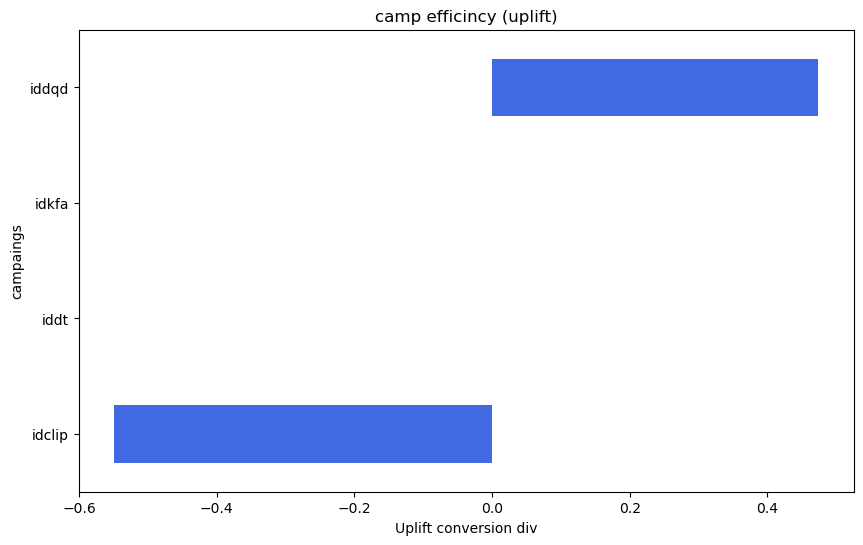

In [116]:
# Расчет эффективности кампаний через uplift
uplift_data = res_target.groupby(["campaing_id", "t_flag"])[
    "target"].mean().unstack()  # Группировка по ID кампании и флагу тестовой группы, расчет среднего значения целевой переменной
uplift_data['uplift'] = uplift_data[1] - uplift_data[
    0]  # Вычисление uplift как разницы между конверсией в тестовой (1) и контрольной (0) группах

# Отображение топ-5 кампаний с наибольшим uplift
print(uplift_data.sort_values("uplift", ascending=False).head(5))

# Визуализация uplift для всех кампаний
uplift_data['uplift'].sort_values().plot(kind='barh', figsize=(10, 6),
                                         color='royalblue')  # Горизонтальная столбчатая диаграмма с сортировкой по возрастанию uplift
plt.xlabel("Uplift conversion div")
plt.ylabel("campaings")
plt.title("camp efficincy (uplift)")
plt.show()

### выводы
- iddqd - эффективна (uplift 0.474182), контрольная группа 0.0 те никто ничего не купил
- iddt и idkfa - сломаны или провалены (0 на тесте и контроле)
- idclip - плохой результат видимо, тк аплифт -0.549495 для контроля (там покупали) и никто не купил в целевой группе (0). Кампания странная, видимо отпугивала

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [118]:
df = pd.read_csv('data/hw6/target.csv', delimiter=",")
df['report_dt'] = pd.to_datetime(df['report_dt'])
df["report_dt_for_agggs"] = df["report_dt"] - pd.DateOffset(months=2)
df["report_dt_for_agggs"] = df["report_dt_for_agggs"].dt.to_period("M").dt.to_timestamp() + pd.offsets.MonthEnd(0)
df

,user_id,campaing_id,report_dt,t_flag,target,report_dt_for_agggs
0,1099975,idclip,2024-11-06,1,0,2024-09-30
1,24623,iddqd,2024-11-01,0,0,2024-09-30
2,4001330,iddt,2024-11-01,0,0,2024-09-30
3,2008409,idkfa,2024-11-04,1,0,2024-09-30
4,4045746,iddt,2024-11-04,1,0,2024-09-30
...,...,...,...,...,...,...
459995,159974,idclip,2024-11-01,0,0,2024-09-30
459996,159993,idclip,2024-11-01,0,0,2024-09-30
459997,159995,idclip,2024-11-01,0,0,2024-09-30
459998,159997,idclip,2024-11-01,0,0,2024-09-30


In [120]:
aggs_with_df = df.merge(
    aggs,
    how="left",
    left_on=["user_id", "report_dt_for_agggs"],
    right_on=["user_id", "report_dt"],
    suffixes=("", "_agggs")
)
aggs_with_df

,user_id,campaing_id,report_dt,t_flag,target,report_dt_for_agggs,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt_agggs,age,city
0,1099975,idclip,2024-11-06,1,0,2024-09-30,0.822461,1.233201,-1.000185,2.585873,-0.584520,-0.268274,-0.727814,1.606372,1.814158,2024-09-30,42,Moscow
1,24623,iddqd,2024-11-01,0,0,2024-09-30,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,2024-09-30,39,Ufa
2,4001330,iddt,2024-11-01,0,0,2024-09-30,-1.821441,-0.847392,1.020568,-1.611153,0.933913,0.236984,0.933495,0.795683,-0.812175,2024-09-30,30,Smolensk
3,2008409,idkfa,2024-11-04,1,0,2024-09-30,-1.952636,-0.479671,1.067760,-1.521329,-0.687298,0.327018,1.052708,1.244605,-0.886796,2024-09-30,25,Moscow
4,4045746,iddt,2024-11-04,1,0,2024-09-30,1.768029,-1.560275,0.533826,-1.815031,-0.456184,0.274609,0.077484,0.452296,-0.224605,2024-09-30,21,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459995,159974,idclip,2024-11-01,0,0,2024-09-30,1.710690,0.139903,2.300344,-0.983370,1.386517,0.681411,1.499215,-0.767443,0.292852,2024-09-30,41,Ufa
459996,159993,idclip,2024-11-01,0,0,2024-09-30,1.436845,1.795722,1.836652,-1.811271,3.406144,-0.292144,0.563129,-1.056622,0.797376,2024-09-30,22,Moscow
459997,159995,idclip,2024-11-01,0,0,2024-09-30,2.889450,-0.877957,1.763199,-2.423527,2.500322,-0.560601,1.610348,-0.745781,1.224924,2024-09-30,43,Smolensk
459998,159997,idclip,2024-11-01,0,0,2024-09-30,0.925286,0.620039,1.685855,-2.097477,1.010336,-0.109139,0.635583,-1.300016,0.297277,2024-09-30,43,Ufa


In [126]:
print(aggs_with_df.isna().sum())  # start eda
print(f"{aggs_with_df.duplicated().sum()=}")
print(f"{aggs_with_df.dtypes=}")

user_id                0
campaing_id            0
report_dt              0
t_flag                 0
target                 0
report_dt_for_agggs    0
x1                     0
x2                     0
x3                     0
x4                     0
x5                     0
x6                     0
x7                     0
x8                     0
x9                     0
report_dt_agggs        0
age                    0
city                   0
dtype: int64
aggs_with_df.duplicated().sum()=0
aggs_with_df.dtypes=user_id                         int64
campaing_id                    object
report_dt              datetime64[ns]
t_flag                          int64
target                          int64
report_dt_for_agggs    datetime64[ns]
x1                            float64
x2                            float64
x3                            float64
x4                            float64
x5                            float64
x6                            float64
x7                         

In [129]:
# Выявление и удаление кампаний с нулевой конверсией
camp_without_res = aggs_with_df.groupby("campaing_id")['target'].mean()  # Расчет средней конверсии по каждой кампании
broken_campaigns = camp_without_res[camp_without_res == 0].index.tolist()  # Определение кампаний с нулевой конверсией
print(f"{broken_campaigns=} - drop them")  # Вывод списка кампаний для удаления

# Фильтрация данных, исключая проблемные кампании
aggs_with_df = aggs_with_df[
    ~aggs_with_df['campaing_id'].isin(broken_campaigns)]  # Удаление строк с кампаниями, имеющими нулевую конверсию
print(f"{aggs_with_df.shape=}")  # Вывод размерности отфильтрованного датасета

broken_campaigns=['iddt', 'idkfa'] - drop them
aggs_with_df.shape=(220000, 18)


In [130]:
print(aggs_with_df["t_flag"].value_counts(normalize=True))  # группы достаточно сбалансированы

t_flag
0    0.554382
1    0.445618
Name: proportion, dtype: float64


In [132]:
# Проверка сбалансированности групп по возрасту
control_age = aggs_with_df[aggs_with_df["t_flag"] == 0]["age"]  # Выделяем возраст в контрольной группе
t_age = aggs_with_df[aggs_with_df["t_flag"] == 1]["age"]  # Выделяем возраст в тестовой группе
t_stat, p_value = ttest_ind(control_age, t_age)  # Выполняем двухвыборочный t-тест для независимых выборок
print(f"age t-test p-value = {p_value:.3f}")

age t-test p-value = 0.949


- P-значение t-теста для возраста (0.949) значительно превышает стандартный порог 0.05, что указывает на отсутствие статистически значимых различий в возрасте между контрольной и тестовой группами. Это очень хороший результат, подтверждающий качественную рандомизацию - группы хорошо сбалансированы по возрасту, что исключает этот фактор как возможную причину различий в конверсии между группами. Такая сбалансированность повышает валидность результатов A/B-теста и позволяет с большей уверенностью утверждать, что наблюдаемые эффекты действительно вызваны маркетинговыми воздействиями, а не различиями в составе групп.

In [134]:
# Анализ распределения городов в контрольной и тестовой группах
city_crosstab = pd.crosstab(aggs_with_df["t_flag"],
                            aggs_with_df["city"])  # Создание кросс-таблицы: строки - t_flag (0/1), столбцы - города
print(f"{city_crosstab=}")

city_crosstab=city    Moscow  Smolensk    Ufa
t_flag                         
0        40615     40471  40878
1        32657     32495  32884


In [137]:
# Анализ статистики по пользователям и покупкам в разрезе кампаний и групп
camp_stats = aggs_with_df.groupby(["campaing_id", "t_flag"]).agg(total_users=("user_id", "count"),  # Подсчет пользователей
                                                                purchases=("target", "sum")).reset_index()  # Подсчет покупок
print(camp_stats)  # Вывод агрегированной статистики

# Детальный анализ покупок в каждой кампании по группам (контрольная/тестовая)
campaigns = aggs_with_df["campaing_id"].unique()  # Получение списка уникальных ID кампаний
for campaign in campaigns:
   campaign_data = camp_stats[camp_stats["campaing_id"] == campaign]  # Фильтрация данных для текущей кампании

   # Извлечение числа покупок в контрольной группе
   control_purch = campaign_data[campaign_data["t_flag"] == 0]["purchases"].values[0]

   # Извлечение числа покупок в тестовой группе
   treatment_purch = campaign_data[campaign_data["t_flag"] == 1]["purchases"].values[0]

   # Вывод информации о наличии/отсутствии покупок в контрольной группе
   print(
       f"{campaign=}: no purch in control group" if control_purch == 0 else f"{campaign=}: have purch in control group")

   # Вывод информации о наличии/отсутствии покупок в тестовой группе
   print(
       f"{campaign=}: no purch in treatment group" if treatment_purch == 0 else f"{campaign=}: have purch in treatment group")

  campaing_id  t_flag  total_users  purchases
0      idclip       0        41964      23059
1      idclip       1        60000          0
2       iddqd       0        80000          0
3       iddqd       1        38036      18036
campaign='idclip': have purch in control group
campaign='idclip': no purch in treatment group
campaign='iddqd': no purch in control group
campaign='iddqd': have purch in treatment group


In [139]:
aggs_with_df.to_csv('data/hw6/target_eda.csv', index=False)


### выводы
- iddt и idkfa удалены из-за отсутствия покупок в обеих группах => Размер данных уменьшился 460000 -> 220000 строк (47%)
- Соотношение контрольной и целевой групп достаточно сбалансировано (55% vs 45%)
- T-тест подтвердил отсутствие значимых различий в возрасте между группами (p=0.949)
- Кампания iddqd продемонстрировала положительный uplift. B контрольной группе 0, в целевой - 18k, кампания iddqd успешна и рекомендуется для дальнейшего анализа и моделирования
- Кампания idclip показала отрицательный uplift. Вероятно Она отпугивает покупателей или ошибка в выборе целевой группы

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve

# from causalml.inference.tree import UpliftRandomForestClassifier
import optuna
df = pd.read_csv('data/hw6/target_eda.csv', sep=',')
df['report_dt'] = pd.to_datetime(df['report_dt'])
df['report_dt_for_agggs'] = pd.to_datetime(df['report_dt_for_agggs'])
df['report_dt_agggs'] = pd.to_datetime(df['report_dt_agggs'])
df

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [159]:
df['m'] = df['report_dt'].dt.month # add month
df['dow'] = df['report_dt'].dt.dayofweek
df['d_diff'] = (df['report_dt'] - df['report_dt_for_agggs']).dt.days
df

,user_id,campaing_id,report_dt,t_flag,target,report_dt_for_agggs,x1,x2,x3,x4,...,x6,x7,x8,x9,report_dt_agggs,age,city,m,dow,d_diff
0,1099975,idclip,2024-11-06,1,0,2024-09-30,0.822461,1.233201,-1.000185,2.585873,...,-0.268274,-0.727814,1.606372,1.814158,2024-09-30,42,Moscow,11,2,37
1,24623,iddqd,2024-11-01,0,0,2024-09-30,2.281651,-0.354332,1.288191,-2.754188,...,0.831745,-0.002779,-1.463527,1.976755,2024-09-30,39,Ufa,11,4,32
2,1106346,idclip,2024-11-05,1,0,2024-09-30,-1.902137,0.322546,2.759591,-0.705195,...,0.205020,-0.647572,1.405190,-1.614184,2024-09-30,32,Moscow,11,1,36
3,116064,iddqd,2024-11-01,0,0,2024-09-30,-0.773911,1.877601,0.582218,1.699295,...,-0.018505,0.337289,-1.101638,-0.936927,2024-09-30,33,Ufa,11,4,32
4,139714,iddqd,2024-11-01,0,0,2024-09-30,0.457746,1.407223,0.803963,-2.002316,...,-1.389908,-1.823737,-0.512010,1.840791,2024-09-30,27,Ufa,11,4,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219995,159974,idclip,2024-11-01,0,0,2024-09-30,1.710690,0.139903,2.300344,-0.983370,...,0.681411,1.499215,-0.767443,0.292852,2024-09-30,41,Ufa,11,4,32
219996,159993,idclip,2024-11-01,0,0,2024-09-30,1.436845,1.795722,1.836652,-1.811271,...,-0.292144,0.563129,-1.056622,0.797376,2024-09-30,22,Moscow,11,4,32
219997,159995,idclip,2024-11-01,0,0,2024-09-30,2.889450,-0.877957,1.763199,-2.423527,...,-0.560601,1.610348,-0.745781,1.224924,2024-09-30,43,Smolensk,11,4,32
219998,159997,idclip,2024-11-01,0,0,2024-09-30,0.925286,0.620039,1.685855,-2.097477,...,-0.109139,0.635583,-1.300016,0.297277,2024-09-30,43,Ufa,11,4,32


In [160]:
print(df['city'].value_counts()) # ohe this
df = pd.get_dummies(df, columns=['campaing_id', 'city'], dtype=float, drop_first=True)
df_prepared = df.drop(columns=['report_dt', 'report_dt_for_agggs', 'report_dt_agggs'], inplace=True)
df_prepared

city
Ufa         73762
Moscow      73272
Smolensk    72966
Name: count, dtype: int64


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220000 entries, 0 to 219999
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            220000 non-null  int64  
 1   t_flag             220000 non-null  int64  
 2   target             220000 non-null  int64  
 3   x1                 220000 non-null  float64
 4   x2                 220000 non-null  float64
 5   x3                 220000 non-null  float64
 6   x4                 220000 non-null  float64
 7   x5                 220000 non-null  float64
 8   x6                 220000 non-null  float64
 9   x7                 220000 non-null  float64
 10  x8                 220000 non-null  float64
 11  x9                 220000 non-null  float64
 12  age                220000 non-null  int64  
 13  m                  220000 non-null  int32  
 14  dow                220000 non-null  int32  
 15  d_diff             220000 non-null  int64  
 16  ca

In [167]:
# Выделение признаков для моделирования
features = [col for col in df.columns if col.startswith('x')] + ['m', 'dow', 'd_diff', 'age']  # Числовые признаки: x-переменные, временные характеристики и возраст
categorical_features = [ 'city_Smolensk', 'city_Ufa', 'campaing_id_iddqd']  # Категориальные признаки: флаги кампаний и городов

# Формирование матрицы признаков и целевой переменной
X = df[features + categorical_features]  # Объединение всех признаков в матрицу X
y = df['target']  # Целевая переменная (факт конверсии/покупки)
treatment = df['t_flag']  # Флаг принадлежности к тестовой группе для uplift-моделирования

In [169]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(X, y, treatment, test_size=0.25, random_state=42, stratify=treatment)
X_train.shape, X_test.shape

((165000, 16), (55000, 16))

In [170]:
# Масштабирование числовых признаков (нормализация в диапазон [0, 1])
scaler = MinMaxScaler()  # Инициализация масштабирующего преобразователя MinMaxScaler
numeric_features = [col for col in features if col not in categorical_features]  # Определение списка только числовых признаков
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])  # Обучение масштабирования на тренировочных данных и применение
X_test[numeric_features] = scaler.transform(X_test[numeric_features])  # Применение того же масштабирования к тестовым данным

In [176]:
!pip uninstall xgboost -y
!pip install xgboost --no-cache-dir
!pip install --no-cache-dir --upgrade xgboost
!pip install --no-cache-dir --upgrade causalml


Found existing installation: xgboost 3.0.0
Uninstalling xgboost-3.0.0:
  Successfully uninstalled xgboost-3.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 11.2 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: causalml
    Found existing installation: causalml 0.15.2
    Uninstalling causalml-0.15.2:
      Successfully uninstalled causalml-0.15.2


In [178]:
from causalml.inference.tree import UpliftRandomForestClassifier
# не заводится у меня в окружении, все доступные методы перепробовал(

ImportError: cannot import name 'make_jcargs' from 'xgboost.core' (/Users/duke/miniconda3/envs/HSE-AI-HW-11/lib/python3.11/site-packages/xgboost/core.py)

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [ ]:
# ваш код здесь

### ваши выводы здесь